In [24]:
%matplotlib inline

In [46]:
import pandas as pd
import statsmodels as sm
import statsmodels.formula.api as smf
import numpy as np
from decimal import Decimal
from matplotlib import pyplot as plt
#from csdid.att_gt import ATTgt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as pgo

In [26]:
# https://theeffectbook.net/ch-DifferenceinDifference.html
df = pd.DataFrame([{'supplier': 'Others', 'y1849': 134.9, 'y1854': 146.6},{'supplier': 'Lambeth', 'y1849': 130.1, 'y1854': 84.9}])
df

supplier  y1849  y1854
0   Others  134.9  146.6
1  Lambeth  130.1   84.9

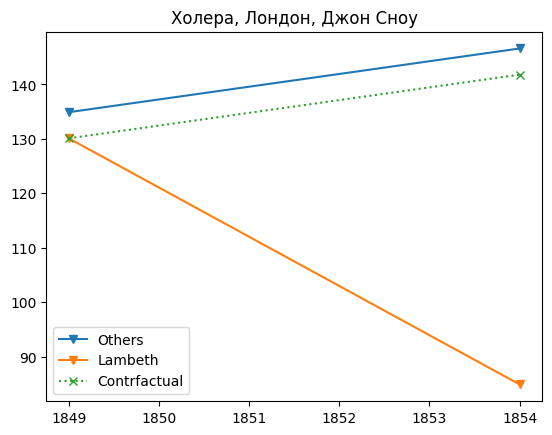

In [27]:
plt.title('Холера, Лондон, Джон Сноу')
plt.plot([1849, 1854], [134.9, 146.6], label='Others', marker='v');
plt.plot([1849, 1854], [130.1, 84.9], label='Lambeth', marker='v');
plt.plot([1849, 1854], [130.1, 130.1+146.6-134.9], label='Contrfactual', marker='x', linestyle=':');
plt.legend();

In [28]:
did = ((84.9 - 130.1) - (146.6 - 134.9))
print(f"{did:.1f}")

-56.9


In [29]:
# Кстати, рядом был монастырь - там никто не умер, потому что пили только пиво, т.е. кипяченую воду с добавками
# Хочется каких-то интервалов к этой точечной оценке - но данные у нас сгруппированы и нам неизвестен размер выборки. 
# Если предположить, что у нас 10 000 человек в каждой выборке (так, с потолка), можно оценить дисперсию биномиального распределения n*p*q и построить доверительный интервал
# У нас тут сумма четырех чисел, дисперсия суммы независимых переменных равна сумме дисперсий, считаем независимыми (ну такое себе - но на холеру иммунитет нестойкий, натянем сову на глобус)
d00 = (134.9)/1000*(1000-134.9)/1000*10_000
d01 = (146.6)/1000*(1000-146.6)/1000*10_000
d10 = (130.1)/1000*(1000-130.1)/1000*10_000
d11 = (84.9)/1000*(1000-84.9)/1000*10_000

#d00, d01, d10, d11
dev = np.sqrt(np.sum([d00, d01, d10, d11]))*1.96
ci0 =(did*10-dev)/10_000
ci1 = (did*10+dev)/10_000
print(f'[{ci0:.3f} {ci1:.3f}]')

[-0.070 -0.044]


In [30]:
# Делайте так, только если ничего лучше сделать нельзя. Реальные данные часто сложно устроены, надо было например посчитать и отнять двойную ковариацию.
# D((X11 - X10) - (X01 - X00)) = D(X11 - X10) -  D(X01 - X00) - 2cov((X11 - X10), (X01 - X00)) и т.д.

In [31]:
df_tidy = pd.DataFrame(
    [
        {'outcome': 134.9, 'treatment': 0, 'time': 0},
        {'outcome': 146.6, 'treatment': 0, 'time': 1},
        {'outcome': 130.1, 'treatment': 1, 'time': 0},
        {'outcome': 84.9, 'treatment': 1, 'time': 1},
    ]
)
df_tidy

outcome  treatment  time
0    134.9          0     0
1    146.6          0     1
2    130.1          1     0
3     84.9          1     1

In [32]:
# мы можем посчитать DiD с помощью линейной регрессии - но чуда не бывает, она не сможет посчитать интервалы
model = smf.ols("outcome ~ treatment*time", data=df_tidy).fit()
model.summary()

/home/dk/.pyenv/versions/2025_kernell2025/lib/python3.12/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/home/dk/.pyenv/versions/2025_kernell2025/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1795: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/home/dk/.pyenv/versions/2025_kernell2025/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1795: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/home/dk/.pyenv/versions/2025_kernell2025/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                outcome   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                 Вс, 19 окт 2025   Prob (F-statistic):                nan
Time:                        16:46:30   Log-Likelihood:                 116.08
No. Observations:                   4   AIC:                            -224.2
Df Residuals:                       0   BIC:                            -226.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        134.9000        inf          0        nan         nan         nan
treatment         -4.8000        inf         -0        nan         nan         nan
time              11.7000        inf          0        nan         nan         nan
treatment:time   -56.9000        inf         -0        nan         nan         nan
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   0.111
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.167
Skew:                           0.000   Prob(JB):                        0.920
Kurtosis:                       2.000   Cond. No.                         6.85
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [33]:
model.params['treatment:time']

-56.89999999999996

In [34]:
# Давайте предположим, что у нас есть данные по 10 000 заболевших человек в каждый из моментов времени, всего 40 000 отсчетов
df_tidy2 = pd.DataFrame(
    [{'outcome': 1, 'treatment': 0, 'time': 0}]*1349 + 
    [{'outcome': 0, 'treatment': 0, 'time': 0}]*(10000-1349) +
    [{'outcome': 1, 'treatment': 0, 'time': 1}] * 1466 + 
    [{'outcome': 0, 'treatment': 0, 'time': 1}] * (10000-1466) + 
    [{'outcome': 1, 'treatment': 1, 'time': 0}] * 1301 +
    [{'outcome': 0, 'treatment': 1, 'time': 0}] * (10000-1301) +
    [{'outcome': 1, 'treatment': 1, 'time': 1}] * 849 + 
    [{'outcome': 0, 'treatment': 1, 'time': 1}] * (10000 - 849)
)
df_tidy2.head()

outcome  treatment  time
0        1          0     0
1        1          0     0
2        1          0     0
3        1          0     0
4        1          0     0

In [35]:
# Наш линейный паравозик теперь смог
smf.ols("outcome ~ treatment*time", data=df_tidy2).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                outcome   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     67.65
Date:                 Вс, 19 окт 2025   Prob (F-statistic):           1.25e-43
Time:                        16:46:39   Log-Likelihood:                -12276.
No. Observations:               40000   AIC:                         2.456e+04
Df Residuals:                   39996   BIC:                         2.460e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.1349      0.003     41.015      0.000       0.128       0.141
treatment         -0.0048      0.005     -1.032      0.302      -0.014       0.004
time               0.0117      0.005      2.515      0.012       0.003       0.021
treatment:time    -0.0569      0.007     -8.650      0.000      -0.070      -0.044
==============================================================================
Omnibus:                    16476.520   Durbin-Watson:                   0.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            50755.171
Skew:                           2.262   Prob(JB):                         0.00
Kurtosis:                       6.161   Cond. No.                         6.85
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [36]:
# Предположим, что это одни и те же люди в выборках
np.random.seed(20251006)

df_tidy3 = df_tidy2.assign(idname= np.concatenate([np.random.permutation(np.arange(0, 10000, 1))]+[np.random.permutation(np.arange(0, 10000, 1))]+[np.random.permutation(np.arange(10000, 20000, 1))]+[np.random.permutation(np.arange(10000, 20000, 1))]))
df_tidy3.head()

outcome  treatment  time  idname
0        1          0     0    6495
1        1          0     0    2909
2        1          0     0    3034
3        1          0     0    8694
4        1          0     0    5276

In [37]:
df_tidy3.tail()

outcome  treatment  time  idname
39995        0          1     1   14742
39996        0          1     1   19178
39997        0          1     1   17137
39998        0          1     1   19053
39999        0          1     1   13372

In [38]:
# https://github.com/py-econometrics/pyfixest
import pyfixest as pf

In [39]:
model = ATTgt(yname = "outcome",
              gname = "treatment", # The variable in '{gname}' should be expressed as the time a unit is first treated (0 if never-treated).
              idname = "idname",
              tname = "time",
              xformla = "outcome~1", # эндогенные переменные, нет конфаундеров - переменных, влияющих на выбор лечения и результат одновременно. Синтаксис xformla = "outcome~ covariate1 + covariate2" или "outcome~1" если их нет
              data = df_tidy3,
              ).fit(est_method = 'dr')
model.summ_attgt().summary2

Group  Time  ATT(g, t)  Post  Std. Error  [95% Pointwise  Conf. Band]   
0      1     1    -0.0569     1      0.0065         -0.0699      -0.0439  *

In [40]:
# A three-sided formula string using fixest formula syntax.
# Syntax: "Y ~ X1 + X2 | FE1 + FE2 | X1 ~ Z1". "|" separates dependent variable,
# fixed effects, and instruments. Special syntax includes stepwise regressions,
# cumulative stepwise regression, multiple dependent variables,
# interaction of variables (i(X1,X2)), and interacted fixed effects (fe1^fe2).

pf.feols("outcome ~ treatment:time + time | idname", data=df_tidy3).summary()

###

Estimation:  OLS
Dep. var.: outcome, Fixed effects: idname
Inference:  CRV1
Observations:  40000

| Coefficient    |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:---------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| time           |      0.012 |        0.005 |     2.374 |      0.018 |  0.002 |   0.021 |
| treatment:time |     -0.057 |        0.007 |    -8.633 |      0.000 | -0.070 |  -0.044 |
---
RMSE: 0.233 R2: 0.501 R2 Within: 0.005 


In [18]:
df = pd.read_csv("data/correlates2-6.csv").loc[lambda x: (x.year >= 2001) & (x.year <= 2004) & x.state.isin({'Illinois', 'New Jersey'})]
df.head()

/tmp/ipykernel_642805/2580811361.py:1: DtypeWarning: Columns (487,491,497,499,502,504,508,511,518,523,525,530,1496,1871,2106,2269,2270,2271,2272,2273,2274,2275,2276) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/correlates2-6.csv").loc[lambda x: (x.year >= 2001) & (x.year <= 2004) & x.state.isin({'Illinois', 'New Jersey'})]


st  stateno       state  state_fips  state_icpsr  year  popdensity  \
1795  IL     13.0    Illinois          17           21  2001         NaN   
1796  IL     13.0    Illinois          17           21  2002         NaN   
1797  IL     13.0    Illinois          17           21  2003         NaN   
1798  IL     13.0    Illinois          17           21  2004         NaN   
3852  NJ     30.0  New Jersey          34           12  2001         NaN   

      popfemale  pctpopfemale    popmale  ...  num_enacted_laws  gunhomicides  \
1795        NaN           NaN        NaN  ...               0.0         262.0   
1796  6400000.0           NaN  6200000.0  ...               0.0         450.0   
1797  6400000.0           NaN  6200000.0  ...               0.0         394.0   
1798  6500000.0           NaN  6200000.0  ...               0.0         357.0   
3852        NaN           NaN        NaN  ...               0.0         106.0   

      femmurdersfamilybygun  mass_shooting_num  numregdvgunlawenact  intropot  \
1795                    3.0                1.0                  2.0       NaN   
1796                    7.0                0.0                  2.0       NaN   
1797                    6.0                0.0                  2.0       NaN   
1798                    3.0                0.0                  1.0       NaN   
3852                    3.0                0.0                  2.0       NaN   

      signedpot  introcat1pot  introcat2pot  introcat3pot  
1795        NaN           NaN           NaN           NaN  
1796        NaN           NaN           NaN           NaN  
1797        NaN           NaN           NaN           NaN  
1798        NaN           NaN           NaN           NaN  
3852        NaN           NaN           NaN           NaN  

[5 rows x 3020 columns]

In [262]:
# Надо ли учить детей эмигрантов
pf.feols("firms_susb ~ immigration_instate_tuition_illegalimmigrants | state+year", data=df).summary()

###

Estimation:  OLS
Dep. var.: firms_susb, Fixed effects: state+year
Inference:  CRV1
Observations:  8

| Coefficient                                   |   Estimate |   Std. Error |              t value |   Pr(>|t|) |     2.5% |    97.5% |
|:----------------------------------------------|-----------:|-------------:|---------------------:|-----------:|---------:|---------:|
| immigration_instate_tuition_illegalimmigrants |   1492.000 |        0.000 | 4295762360318458.500 |      0.000 | 1492.000 | 1492.000 |
---
RMSE: 144.008 R2: 1.0 R2 Within: 0.87 


In [264]:
df[['state', 'year', 'immigration_instate_tuition_illegalimmigrants', 'firms_susb']]

state  year  immigration_instate_tuition_illegalimmigrants  \
1795    Illinois  2001                                            0.0   
1796    Illinois  2002                                            0.0   
1797    Illinois  2003                                            1.0   
1798    Illinois  2004                                            1.0   
3852  New Jersey  2001                                            0.0   
3853  New Jersey  2002                                            0.0   
3854  New Jersey  2003                                            0.0   
3855  New Jersey  2004                                            0.0   

      firms_susb  
1795    252908.0  
1796    253720.0  
1797    255813.0  
1798    259734.0  
3852    202240.0  
3853    203467.0  
3854    204211.0  
3855    207431.0

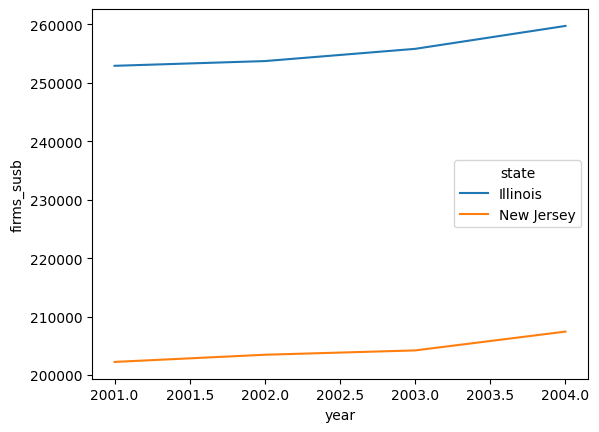

In [269]:
# Как похорошел Иллинойс при Байдене!
sns.lineplot(data=df, x="year", y="firms_susb", hue='state');

In [41]:
from pysyncon import Dataprep, Synth
# см https://mixtape.scunning.com/10-synthetic_control

In [88]:
df = pd.read_csv("https://raw.githubusercontent.com/sdfordham/pysyncon/refs/heads/main/data/texas.csv")

dataprep = Dataprep(
    foo=df,
    predictors=["income", "ur", "poverty"],
    predictors_op="mean",
    time_predictors_prior=range(1985, 1994),
    special_predictors=[
        ("bmprison", [1988], "mean"),
        ("bmprison", [1990], "mean"),
        ("bmprison", [1991], "mean"),
        ("bmprison", [1992], "mean"),
        ("alcohol", [1990], "mean"),
        ("aidscapita", [1990], "mean"),
        ("aidscapita", [1991], "mean"),
        ("black", [1990], "mean"),
        ("black", [1991], "mean"),
        ("black", [1992], "mean"),
        ("perc1519", [1990], "mean"),
    ],
    dependent="bmprison",
    unit_variable="state",
    time_variable="year",
    treatment_identifier="Texas",
    controls_identifier=[
        "Alabama",
        "Alaska",
        "Arizona",
        "Arkansas",
        "California",
        "Colorado",
        "Connecticut",
        "Delaware",
        "District of Columbia",
        "Florida",
        "Georgia",
        "Hawaii",
        "Idaho",
        "Illinois",
        "Indiana",
        "Iowa",
        "Kansas",
        "Kentucky",
        "Louisiana",
        "Maine",
        "Maryland",
        "Massachusetts",
        "Michigan",
        "Minnesota",
        "Mississippi",
        "Missouri",
        "Montana",
        "Nebraska",
        "Nevada",
        "New Hampshire",
        "New Jersey",
        "New Mexico",
        "New York",
        "North Carolina",
        "North Dakota",
        "Ohio",
        "Oklahoma",
        "Oregon",
        "Pennsylvania",
        "Rhode Island",
        "South Carolina",
        "South Dakota",
        "Tennessee",
        "Utah",
        "Vermont",
        "Virginia",
        "Washington",
        "West Virginia",
        "Wisconsin",
        "Wyoming",
    ],
    time_optimize_ssr=range(1985, 1994),
)

print(dataprep)

Dataprep
Treated unit: Texas
Dependent variable: bmprison
Control units: Alabama, Alaska, Arizona, Arkansas, California, Colorado, Connecticut, Delaware, District of Columbia, Florida, Georgia, Hawaii, Idaho, Illinois, Indiana, Iowa, Kansas, Kentucky, Louisiana, Maine, Maryland, Massachusetts, Michigan, Minnesota, Mississippi, Missouri, Montana, Nebraska, Nevada, New Hampshire, New Jersey, New Mexico, New York, North Carolina, North Dakota, Ohio, Oklahoma, Oregon, Pennsylvania, Rhode Island, South Carolina, South Dakota, Tennessee, Utah, Vermont, Virginia, Washington, West Virginia, Wisconsin, Wyoming
Time range in data: 1985.0 - 2000.0
Time range for loss minimization: range(1985, 1994)
Time range for predictors: range(1985, 1994)
Predictors: income, ur, poverty
Special predictors:
    `bmprison` over `[1988]` using `mean`
    `bmprison` over `[1990]` using `mean`
    `bmprison` over `[1991]` using `mean`
    `bmprison` over `[1992]` using `mean`
    `alcohol` over `[1990]` using `mea

In [89]:
synth = Synth()
synth.fit(dataprep=dataprep, optim_method="BFGS", optim_initial="ols")

synth.weights(threshold=0.1)

California    0.409
Florida       0.108
Illinois      0.361
Louisiana     0.122
Name: weights, dtype: float64

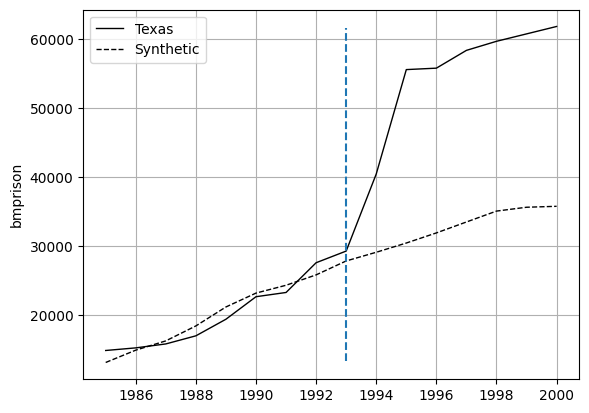

In [90]:
synth.path_plot(time_period=range(1985, 2001), treatment_time=1993)

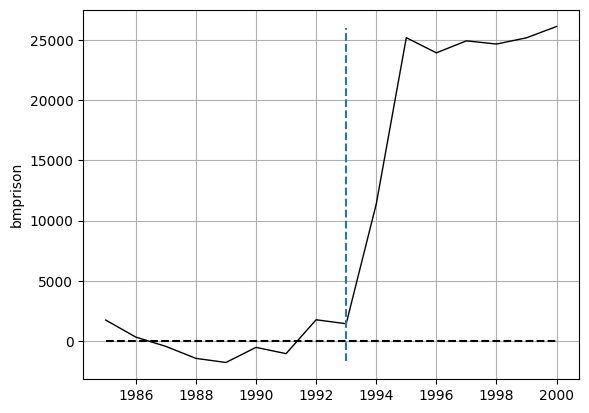

In [91]:
synth.gaps_plot(time_period=range(1985, 2001), treatment_time=1993)

In [92]:
synth.att(time_period=range(1993, 2001))

{'att': 20339.375838131393, 'se': 3190.4946788704715}

In [93]:
synth.summary()

V    treated  synthetic  sample mean
income                0.000  16485.778  19003.932    17480.102
ur                    0.000      7.399      7.314        6.167
poverty               0.000     17.222     15.169       13.492
special.1.bmprison    0.041  16956.000  18394.431     4872.160
special.2.bmprison    0.041  22634.000  23159.063     6098.230
special.3.bmprison    0.056  23249.000  24296.887     6560.480
special.4.bmprison    0.145  27568.000  25803.122     6971.660
special.5.alcohol     0.000      2.470      2.712        2.504
special.6.aidscapita  0.015     13.590     15.006        8.763
special.7.aidscapita  0.016     14.835     17.252       10.126
special.8.black       0.172     16.155     15.991       11.288
special.9.black       0.443     16.300     16.179       11.418
special.10.black      0.070     16.460     16.385       11.566
special.11.perc1519   0.000      7.703      7.030        7.193